## VQE and Quantum Graph Neural Networks

In [3]:
import numpy
import math
import random
import numpy as np
import scipy
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
import networkx as nx
import cirq

In order to begin thinking about the quantum graph neural network, we must prepare some training data. We perform VQE in order to find the ground state of a given Ising model Hamiltonian:

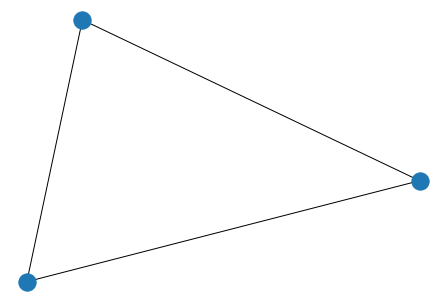

[[3.7, 7.2, 9.0], [9.6, 8.9, 1.1]]


In [21]:
# Initialize the necessary qubits

qubit_number = 3
data_register = [cirq.GridQubit(0, i) for i in range(0, qubit_number)]
network_register = [cirq.GridQubit(1, i) for i in range(0, qubit_number)]

# Creates the graph structure of the quantum system

ising_graph = nx.Graph()
ising_graph.add_nodes_from(range(0, qubit_number))
ising_graph.add_edges_from([(0, 1), (1, 2), (2, 0)])

nx.draw(ising_graph)
plt.show() 

# Creates parameters

matrix_params = [[random.randint(10, 100)/10 for i in range(0, qubit_number)] for j in range(0, 2)]
print(matrix_params)

In [22]:
# Defines the rz gate:

def rz(control, target, param):
    yield cirq.CX.on(control, target)
    yield cirq.rz(param).on(target)
    yield cirq.CX.on(control, target)

# Method that initializes qubits in even superposition

def even_superposition(qubits):
    
    for i in qubits:
        yield cirq.H.on(i)

# Method that prepares the QAOA ansatz layers

def qaoa_layer(param1, param2, qubits, ising_graph):
    
    # Applies another layer of coupling gates
    for count, i in enumerate(ising_graph.edges):
        yield rz(qubits[i[0]], qubits[i[1]], 2*param1[count])
    
    # Applies the final layer of RX gates on the qubits
    
    for i in range(0, len(qubits)):
        yield cirq.rx(2*param2[i]).on(qubits[i])
    
# Method that prepares the decoupled layers

def decoupled_layer(param1, param2, qubits):
    
    for i in range(0, len(qubits)):
        yield cirq.ZPowGate(exponent=param1[i]).on(qubits[i])
        yield cirq.XPowGate(exponent=param1[i]).on(qubits[i])

# Method that prepares the VQE circuit that will be used to 

def vqe_circuit(parameters, qubits, ising_graph):
    
    yield decoupled_layer(parameters[0], parameters[1], qubits) 
    yield decoupled_layer(parameters[2], parameters[3], qubits)

test_circuit = cirq.Circuit()
test_circuit.append(vqe_circuit([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], data_register, ising_graph))
print(test_circuit)

(0, 0): ───Z───X───Z───X───

(0, 1): ───Z───X───Z───X───

(0, 2): ───Z───X───Z───X───


In [23]:
# Creates the Hamiltonian that we are attempting to learn

def create_hamiltonian_matrix(n, graph):
    
    # Defines Pauli matrices

    pauli_x = np.array([[0, 1], [1, 0]])
    pauli_y = np.array([[0, -1j], [1j, 0]])
    pauli_z = np.array([[1, 0], [0, -1]])
    identity = np.array([[1, 0], [0, 1]])

    matrix = np.zeros((2**n, 2**n))
    
    # Creates the interaction component of the Hamiltonian

    for count, i in enumerate(graph.edges):
        m = 1
        for j in range(0, n):
            if (i[0] == j or i[1] == j):
                m = np.kron(m, pauli_z)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[0][count]*m)
    
    # Creates the "bias" component of the matrix
    
    for i in range(0, n):
        m = 1
        for j in range(0, n):
            if (j == i):
                m = np.kron(m, pauli_x)
            else:
                m = np.kron(m, identity)
        matrix = np.add(matrix, matrix_params[1][i]*m)

    return matrix

print(create_hamiltonian_matrix(qubit_number, ising_graph))

[[ 19.9   1.1   8.9   0.    9.6   0.    0.    0. ]
 [  1.1 -12.5   0.    8.9   0.    9.6   0.    0. ]
 [  8.9   0.   -5.5   1.1   0.    0.    9.6   0. ]
 [  0.    8.9   1.1  -1.9   0.    0.    0.    9.6]
 [  9.6   0.    0.    0.   -1.9   1.1   8.9   0. ]
 [  0.    9.6   0.    0.    1.1  -5.5   0.    8.9]
 [  0.    0.    9.6   0.    8.9   0.  -12.5   1.1]
 [  0.    0.    0.    9.6   0.    8.9   1.1  19.9]]


-24.24394126039646


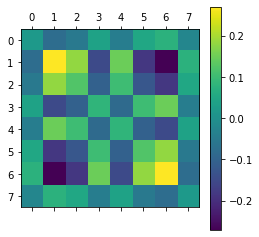

In [24]:
def create_density_matrix(arr):
    
    array = np.array(arr)
    plt.matshow(array)
    plt.colorbar()
    plt.show()

# Finds the eigenvector corresponding to the lowest energy state
    
val, vec = np.linalg.eig(create_hamiltonian_matrix(qubit_number, ising_graph))
m = []

min_ind = list(val).index(min(val))
print(val[min_ind])
for i in range(0, 2**qubit_number):
    m.append(vec[i][min_ind])

'''
def apply(n):
    return float(n*np.conj(n))

func_vec = np.vectorize(apply)
new = func_vec(np.outer(m, m))
'''

create_density_matrix(np.real(np.outer(m, np.conj(m))))

Cost at Step 0= 7.013912234494967
Cost at Step 50= -22.081927109295286
Cost at Step 100= -22.43049245303175
Cost at Step 150= -22.434545478624734
Cost at Step 200= -22.436487784696332
Cost at Step 250= -22.438125959504973
Cost at Step 300= -22.43973168072288
Cost at Step 350= -22.440243926873343
Cost at Step 400= -22.44023185995141
Cost at Step 450= -22.440241969657897
Cost at Step 500= -22.44024840707309
     fun: -22.44024840707309
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 504
  status: 1
 success: True
       x: array([ 2.06761098,  0.71031451,  2.93768473,  1.14064772,  0.8862896 ,
        1.47239264,  2.78201902, -0.1153096 ,  1.48542958,  2.0314233 ,
        1.97168219,  0.34467008])


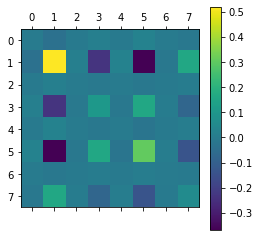

In [26]:
# Creates the VQE method that we will optimize

def create_circuit(parameters, qubits):
    
    # Prepares the circuit
    
    circuit = cirq.Circuit()
    circuit.append(even_superposition(qubits))
    circuit.append(vqe_circuit(parameters, qubits, ising_graph))
    
    # Creates the simulation
    
    simulator = cirq.Simulator()
    results = simulator.simulate(circuit)
    state_vector = results.final_state
    
    return state_vector

# Creates the cost function

iterations = 0

def cost_function(parameters, qubits):
    
    global iterations
    
    hamiltonian = create_hamiltonian_matrix(qubit_number, ising_graph)
    vector = create_circuit(parameters, qubits)
    
    first = np.matmul(hamiltonian, vector)
    cost = np.inner(np.conj(vector), first)
    
    if (iterations%50 == 0):
        print("Cost at Step "+str(iterations)+"= "+str(np.real(cost)))
    
    iterations += 1
    
    return np.real(cost)

# Creates the optimizer for our variational circuit

qubit_register = network_register

def optimizer_cost(params):
    
    parameters = [
        params[0:3], 
        params[3:6],
        params[6:9],
        params[9:12]
    ]
    
    return cost_function(parameters, qubit_register)

# Creates the optimizer

init = [random.randint(0, 20)/10 for i in range(0, 12)]
out = minimize(optimizer_cost, x0=init, method="COBYLA", options={'maxiter':1000, 'tol':1e-10})
g = out['x']
print(out)

# Prepares the optimal state and visualizes it

optimal_params = [
        g[0:3], 
        g[3:6],
        g[6:9],
        g[9:12]
    ]

optimal = create_circuit(optimal_params, qubit_register)
result = np.real(np.outer(optimal, np.conj(optimal)))
create_density_matrix(result)

v = [ 3.21629331,  0.54890376,  2.02976445,  0.7818173 ,  1.3213677 ,
        1.48080682,  1.67054856,  1.44101918,  1.20196752,  0.56441884,
       -0.31570509,  0.15785939,  1.69543663,  0.72541886,  0.02910459,
       -0.52821689]

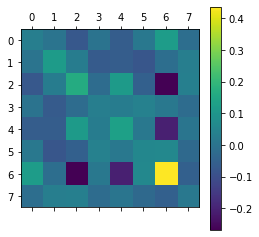

In [27]:
hbar = 1

# Attempts to evolve the prepared ground state forward in time, with the time evolution circuit

def le_state_evolve(depth, time, qubits, ising_graph, params):
    
    yield even_superposition(qubits)
    yield vqe_circuit(params, qubits, ising_graph)
    for i in range(0, depth):
        yield qaoa_layer([i*time/depth for i in matrix_params[0]], [i*time/depth for i in matrix_params[1]], qubits, ising_graph)

# Creates the circuit

def create_time_circuit(depth, time, qubits, ising_graph, params):
    
    circuit = cirq.Circuit()
    circuit.append(le_state_evolve(depth, time, qubits, ising_graph, params))
    
    simulator = cirq.Simulator()
    results = simulator.simulate(circuit)
    state_vector = results.final_state
    
    return state_vector

vector = create_time_circuit(800, 10, data_register, ising_graph, optimal_params)
create_density_matrix(np.real(np.outer(vector, np.conj(vector))))

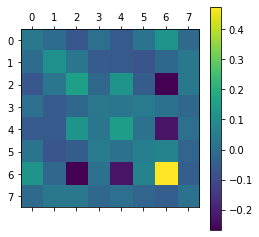

Fidelity: (0.9964847267234284+0j)


In [28]:
# Creates the numrical simulation, to test our time-evolution circuit

def time_evolution_test(time, vec):
    
    new_matrix = scipy.linalg.expm(complex(0,-1)*create_hamiltonian_matrix(qubit_number, ising_graph)*time / hbar)
    return np.matmul(new_matrix, vec)

vec = time_evolution_test(10, optimal)
create_density_matrix(np.real(np.outer(vec, np.conj(vec))))

print("Fidelity: "+str(np.inner(np.conj(vec), vector)*np.inner(np.conj(vector), vec)))

In [29]:
# Creates the initial "guess" graph of interactions, and assigns parameters to each of the edges

initial_graph = nx.complete_graph(qubit_number)

# Creates the SWAP test between two registers of qubits

def swap_test(control, index1, index2):
    
    yield cirq.H.on(control)
    for i in range(0, len(index1)):
        yield cirq.CSWAP(control, index1[i], index2[i])
    yield cirq.H.on(control)

# Creates the QGRNN ansatz

def qgrnn_ansatz(initial_graph, parameters, opt_params, depth, qubits, time):
    
    yield even_superposition(qubits)
    yield vqe_circuit(opt_params, qubits, ising_graph)
    for i in range(0, depth):
        yield qaoa_layer([i*time/depth for i in parameters[0]], [i*time/depth for i in parameters[1]], qubits, initial_graph)

def find_infidelity_time(depth, time, index1, index2, control, params, opt_params, ising_graph, initial_graph):
    
    circuit = cirq.Circuit()
    circuit.append(le_state_evolve(depth, time, index1, ising_graph, opt_params))
    circuit.append(qgrnn_ansatz(initial_graph, params, opt_params, depth, index2, time))
    circuit.append(swap_test(control, index1, index2))
    circuit.append(cirq.measure(control, key="q"))
    
    simulator = cirq.Simulator()
    results = simulator.run(circuit, repetitions=100)
    
    new_res = list(str(results)[2:])
    return sum([int(i) for i in new_res])

control = cirq.GridQubit(2, 0)

In [38]:
# Now, we define the cost function that is used in the optimization method

time_range = range(0, 10)
iterations = 0

def cost_function(params):
    
    global iterations
    
    params = [params[0:3], params[3:6]]
    
    total_cost = 0
    for i in time_range:
        res = find_infidelity_time(50, i, data_register, network_register, control, params, optimal_params, ising_graph, initial_graph)
        total_cost += res
        
    print("Cost at Step "+str(iterations)+": "+str(total_cost / len(time_range)))
    
    iterations += 1
    return total_cost / len(time_range)

print(ising_graph.edges)
print(initial_graph.edges)

[(0, 1), (0, 2), (1, 2)]
[(0, 1), (0, 2), (1, 2)]


In [39]:
init = [random.randint(10, 100)/10 for i in range(0, 6)]
out = minimize(cost_function, x0=init, method="COBYLA", options={'maxiter':500})
g = out['x']
print(out)

Cost at Step 0: 31.9
Cost at Step 1: 35.3
Cost at Step 2: 34.4
Cost at Step 3: 28.7
Cost at Step 4: 27.1
Cost at Step 5: 32.6
Cost at Step 6: 36.3
Cost at Step 7: 28.5
Cost at Step 8: 29.8
Cost at Step 9: 31.4
Cost at Step 10: 28.7
Cost at Step 11: 29.9
Cost at Step 12: 25.8
Cost at Step 13: 25.8
Cost at Step 14: 26.8
Cost at Step 15: 25.4
Cost at Step 16: 26.8
Cost at Step 17: 28.0
Cost at Step 18: 25.5
Cost at Step 19: 28.7
Cost at Step 20: 26.0
Cost at Step 21: 26.9
Cost at Step 22: 26.2
Cost at Step 23: 28.4
Cost at Step 24: 26.1
Cost at Step 25: 30.6
Cost at Step 26: 26.7
Cost at Step 27: 28.6
Cost at Step 28: 25.8
Cost at Step 29: 28.4
Cost at Step 30: 27.8
Cost at Step 31: 27.5
Cost at Step 32: 27.2
Cost at Step 33: 26.0
Cost at Step 34: 29.1
Cost at Step 35: 26.6
Cost at Step 36: 28.5
Cost at Step 37: 26.6
Cost at Step 38: 31.1
Cost at Step 39: 27.3
Cost at Step 40: 26.8
Cost at Step 41: 25.8
Cost at Step 42: 26.5
Cost at Step 43: 26.4
Cost at Step 44: 28.9
Cost at Step 45: 27.